In [1]:
from monitorlib import load_pcdata
import pandas as pd

def sync_positions(data,sample,i):
     # Searching for the cursor position that it is nearest to screenshot timestamp ti 
     # (before or after, it does not matter)
     ti = data[sample]['screenshots']['timestamp'][i]
     abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
     closest_index = abs_diff.idxmin()
     px, py = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
     return px, py

def sync_MKevents(sample_df, data, sample):
     
     def set_value(sample_df, tdiff, event, position=None):
          # Searching for the screenshot immediately before to the M&K event timestamp ti
          closest_index = abs(tdiff[tdiff <= 0]).idxmin()
          if sample_df['mouse_keyboard'][closest_index] != None:
               print('colision between M&K events', sample_df['mouse_keyboard'][closest_index], event)   # what to do?
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          else:
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          if position != None:
               sample_df.loc[closest_index, 'px'] = position[0]
               sample_df.loc[closest_index, 'py'] = position[1]
          
     # Initial values
     sample_df['mouse_keyboard'] = [None for i in range(len(sample_df))]
     timestamps_df = data[sample]['screenshots']['timestamp']

     # Clicks
     for i in range(len(data[sample]['clicks'])):
          ti = data[sample]['clicks']['timestamp'][i]
          button = data[sample]['clicks']['button'][i]
          click_px, click_py = data[sample]['clicks']['px'][i], data[sample]['clicks']['py'][i]
          set_value(sample_df, timestamps_df - ti, button, (click_px,click_py))

     # Scrolls
     for i in range(len(data[sample]['scrolls'])):
          ti = data[sample]['scrolls']['timestamp'][i]
          dy = data[sample]['scrolls']['dy'][i] 
          scroll_px, scroll_py = data[sample]['scrolls']['px'][i], data[sample]['scrolls']['py'][i]
          if dy == 1:
               scroll = 'scroll_down' 
          elif dy == -1:
               scroll = 'scroll_up'
          else:
               scroll = 'what?_scroll'
          set_value(sample_df, timestamps_df - ti, scroll, (scroll_px, scroll_py))
   
     # Keyboard events
     for i in range(len(data[sample]['keys'])):
          ti = data[sample]['keys']['timestamp'][i]
          key = data[sample]['keys']['key'][i].strip("'")
          set_value(sample_df, timestamps_df - ti, key)

def sync(data):
     samples = []
     for sample in data.keys():
          print(f'processing {sample}')
          sample_df = pd.DataFrame()
          sample_df['img_path'] = [img_path for img_path in data[sample]['screenshots']['img_path']]
          
          # Sync cursor positions to screenshots
          positions = [sync_positions(data,sample,i) for i in range(len(data[sample]['screenshots']))]
          sample_df['px'] = [px for px, _ in positions]
          sample_df['py'] = [py for _, py in positions]

          # Sync mouse and keyboard events to screenshots
          sync_MKevents(sample_df, data, sample)

          samples.append(sample_df)
     return samples

data = load_pcdata('data') 

# Syncronization. Order in time: 1) M&K Events, 2) Screenshoots and 3) Cursor positions 
samples = sync(data)

# Replace None values with a string
for sample in samples:
    sample.fillna("no_action",inplace=True)

# tokenization
tokens = set()
for sample in samples:
    tokens.update(sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
print(len(tokens))
print(tokens)

# Add timestamp column
for sample in samples:
    sample['time'] = sample['img_path'].map(lambda x: float(x.split('/')[2].split('_')[-1].split('.jpg')[0]))

samples[0]

processing sample1
processing sample2
processing sample3
processing sample4
colision between M&K events scroll_down scroll_down
processing sample5
processing sample6
processing sample7
7
['Button.left', 'Key.enter', 'Key.esc', 'no_action', 'o', 'scroll_down', 'z']


img_path    px   py  \
0    data/sample1/0000000000_0.04096198081970215.jpg   570  428   
1    data/sample1/0000000001_0.12202715873718262.jpg   570  428   
2    data/sample1/0000000002_0.19535470008850098.jpg   570  428   
3    data/sample1/0000000003_0.26665711402893066.jpg   570  428   
4     data/sample1/0000000004_0.3381388187408447.jpg   570  428   
..                                               ...   ...  ...   
726   data/sample1/0000000726_50.409887075424194.jpg  1360  300   
727    data/sample1/0000000727_50.47743463516235.jpg  1360  300   
728    data/sample1/0000000728_50.54669976234436.jpg  1360  300   
729   data/sample1/0000000729_50.616905212402344.jpg  1360  300   
730    data/sample1/0000000730_50.68598771095276.jpg  1360  300   

    mouse_keyboard       time  
0        no_action   0.040962  
1        no_action   0.122027  
2        no_action   0.195355  
3        no_action   0.266657  
4        no_action   0.338139  
..             ...        ...  
726      no_action  50.409887  
727      no_action  50.477435  
728      no_action  50.546700  
729      no_action  50.616905  
730        Key.esc  50.685988  

[731 rows x 5 columns]

In [2]:
import numpy as np

# Design decision: The last delay is 0.0
# Extract just actions 
a_samples = []
for sample in samples: 
    actions_df = sample[sample['mouse_keyboard'] != 'no_action'].copy()
    delays = actions_df['time'][1:].values - actions_df['time'][0:-1].values
    delays = np.append(delays,0.0)
    actions_df['delay'] = delays
    actions_df = actions_df.reset_index(drop=True)
    a_samples.append(actions_df)
    
for a_sample in a_samples:
    print(len(a_sample))

a_samples[1]

18
17
15
21
15
18
18


img_path    px    py mouse_keyboard  \
0    data/sample2/0000000026_1.887476921081543.jpg  1760    48    Button.left   
1   data/sample2/0000000045_3.2164204120635986.jpg  1258   101              z   
2   data/sample2/0000000049_3.4876980781555176.jpg  1261   101              o   
3     data/sample2/0000000051_3.62322998046875.jpg  1261   101              o   
4    data/sample2/0000000056_3.962639570236206.jpg  1261   101      Key.enter   
5    data/sample2/0000000101_7.049755334854126.jpg  1311   787    Button.left   
6   data/sample2/0000000168_11.603970289230347.jpg   885   534    Button.left   
7   data/sample2/0000000298_20.583450317382812.jpg  1040   560    Button.left   
8   data/sample2/0000000381_26.371670484542847.jpg  1107   289    Button.left   
9   data/sample2/0000000397_27.482587337493896.jpg  1096   726    Button.left   
10     data/sample2/0000000491_33.863116979599.jpg   971   741    Button.left   
11  data/sample2/0000000517_35.586769342422485.jpg   973   763    Button.left   
12   data/sample2/0000000533_36.66414284706116.jpg  1016   780    Button.left   
13  data/sample2/0000000551_37.866411447525024.jpg   934   818    Button.left   
14   data/sample2/0000000593_40.82017183303833.jpg   406  1048    Button.left   
15   data/sample2/0000000605_41.66181516647339.jpg   896   726    Button.left   
16   data/sample2/0000000666_45.93539571762085.jpg  1180   427        Key.esc   

         time     delay  
0    1.887477  1.328943  
1    3.216420  0.271278  
2    3.487698  0.135532  
3    3.623230  0.339410  
4    3.962640  3.087116  
5    7.049755  4.554215  
6   11.603970  8.979480  
7   20.583450  5.788220  
8   26.371670  1.110917  
9   27.482587  6.380530  
10  33.863117  1.723652  
11  35.586769  1.077374  
12  36.664143  1.202269  
13  37.866411  2.953760  
14  40.820172  0.841643  
15  41.661815  4.273581  
16  45.935396  0.000000

In [3]:
# tokenization
tokens = set()
for a_sample in a_samples:
    tokens.update(a_sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
tokens.insert(0,'no_action')
print(len(tokens))
print(tokens)

7
['no_action', 'Button.left', 'Key.enter', 'Key.esc', 'o', 'scroll_down', 'z']


In [4]:
# model design
# Inputs = (screenshots) 
# Outputs = (M&K action as regression, mouse position, delay)

from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

IMGSIZE= [1080//10, 1920//10]
img_transform = transforms.Compose([
                transforms.Resize(IMGSIZE, antialias=None),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.5, 0.5, 0.5],
                #                    std=[0.5, 0.5, 0.5]),
                ])

def normalization(x, max):
    return 2.0*(x/max) - 1.0

class PCDataset(Dataset):
    def __init__(self, samples, root_dir, tokens):
        self.samples = samples
        self.root_dir = root_dir
        self.tokens = tokens
        self.maxtokens = len(tokens)
        self.maxdelay = None
        self.maxlength = None
        self.maxwidth_screenshoot = None
        self.maxheight_screenshoot = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_list, action_list, position_list, delay_list, = [], [], [], []
        for i, img_path in enumerate(self.samples[idx]["img_path"]):
            # Images. Pixel intensities [0,1]
            img = Image.open(self.samples[idx]["img_path"][i])
            imgT = img_transform(img)
            img_list.append(imgT)

            # Mouse-keyboard action [-1,1]
            action_index = self.tokens.index(self.samples[idx]["mouse_keyboard"][i])            
            action_list.append(torch.tensor(normalization(action_index, max=self.maxtokens)))

            # Mouse position [-1,1]
            px = self.samples[idx]["px"][i]
            py = self.samples[idx]["py"][i]
            norm_position = torch.tensor([normalization(px, max=self.maxwidth_screenshoot), 
                              normalization(py, max=self.maxheight_screenshoot)]
                            ) 
            position_list.append(norm_position)
            
            # Delay [0,inf)
            delay = self.samples[idx]["delay"][i]
            norm_delay = torch.tensor([delay/self.maxdelay])
            delay_list.append(norm_delay)

        ### Padding
        padding_dims = self.maxlength-len(img_list)
            # Image features [padding with last image or with zeros features]? o 
        img_list.extend(imgT.expand(torch.Size([padding_dims]) + imgT.shape))
        #img_list.extend(torch.ones(torch.Size([padding_dims]) + imgT.shape))

        x = torch.stack(img_list, 0).type(torch.FloatTensor)
            # Mouse-keyboard action [no_action value]
        noaction_value = normalization(self.tokens.index('no_action'), max=self.maxtokens)
        action_list.extend(torch.tensor(padding_dims*[noaction_value]))
        y_action = torch.stack(action_list, 0).type(torch.FloatTensor)
        y_action = y_action[:,None]
            # Mouse position [0,0]
        position_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_position.shape))    
        y_position = torch.stack(position_list, 0).type(torch.FloatTensor)
            # Delay [0]
        delay_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_delay.shape))    
        y_delay = torch.stack(delay_list, 0).type(torch.FloatTensor)

        return x, [y_action, y_position, y_delay] 
    
dataset = PCDataset(a_samples, root_dir='./', tokens=tokens)
dataset.maxlength = 25  #steps in time
dataset.maxwidth_screenshoot = 1920  #pixels
dataset.maxheight_screenshoot = 1080 #pixels
dataset.maxdelay = 15 #secs

traindata, valdata = torch.utils.data.random_split(dataset,[5, 2])
trainloader = torch.utils.data.DataLoader(traindata, batch_size=5, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=2, shuffle=False, num_workers=10)

/home/ezamorag/miniconda3/envs/automat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([5, 25, 3, 108, 192]) torch.Size([5, 25, 1]) torch.Size([5, 25, 2]) torch.Size([5, 25, 1])


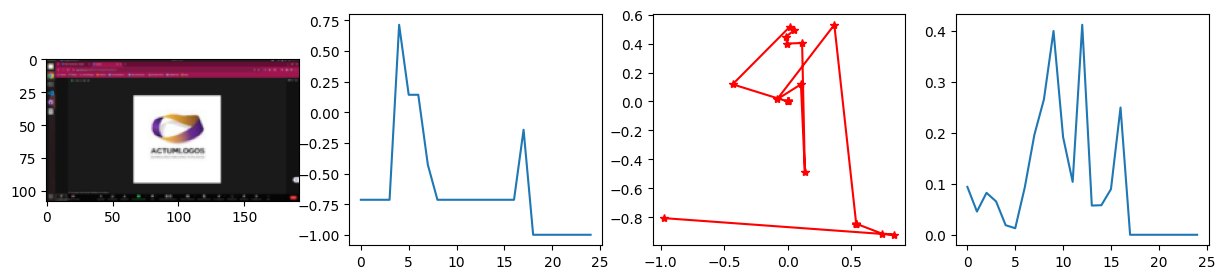

In [5]:
x0, (y1, y2, y3) = next(iter(trainloader))
print(x0.shape, y1.shape, y2.shape, y3.shape)

import matplotlib.pyplot as plt

ib = 0
plt.figure(figsize=(15,3))
plt.subplot(141)
plt.imshow(x0[ib,22,...].permute(1,2,0))
plt.subplot(142)
plt.plot(y1[ib,:])
plt.subplot(143)
plt.plot(y2[ib,:,0], y2[ib,:,1], 'r-*')
plt.subplot(144)
plt.plot(y3[ib,:,0])
plt.show()

# To check sameness at the end 
# [(i,(x0[ib,i,...]-x0[ib,-1,...]).sum()) for i in range(25)]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

PATCH_SIZE = 7
STRIDE = 4
D_DIM = 4
class ImgAttentionDiff(nn.Module):
    def __init__(self, patch_size, stride, d_dim):
        super().__init__()
        self.patch_size = patch_size
        self.d_dim = d_dim
        self.dh_dim = patch_size*patch_size*3
        self.patchify = nn.Unfold(kernel_size=patch_size, stride=stride)
        self.tokeys    = nn.Linear(self.dh_dim, d_dim, bias=False)
        self.toqueries = nn.Linear(self.dh_dim, d_dim, bias=False)
        self.gamma = nn.Parameter(torch.randn(1))  #1.5
        self.epsilon = 1e-10

    def forward(self, img_batch):
        x_tokens = self.patchify(img_batch).permute(0,2,1)
        Qd = self.toqueries(x_tokens)
        Kd = self.tokeys(x_tokens)  
        dot0 = torch.bmm(Qd, Kd.transpose(1, 2))
        dot1 = dot0/(self.d_dim**(1/2)) 
        dot2 = F.softmax(dot1, dim=2)
        raw_importance = dot2.sum(dim=1)

        mu_ones = torch.ones(raw_importance.shape).to(device) 
        sigma = raw_importance.std(dim=1)[:,None].expand(raw_importance.shape)
        norm_importance = self.gamma*(raw_importance-mu_ones)/(sigma + self.epsilon)   #Aqui es donde povoca los valores NAN cuando las iamgenes son uniformes
        selected_importance = F.softmax(norm_importance, dim=1)
        return selected_importance
        
class LSTM14Attention(nn.Module):  
    def __init__(self, h_dim, hfc_dim, img_size, patch_size, stride, d_dim, num_layers=1):
        super().__init__()
        self.imgattention = ImgAttentionDiff(patch_size, stride, d_dim)
        self.num_patches = round((img_size[1]-patch_size)/stride + 1) * round((img_size[0]-patch_size)/stride + 1)

        self.lstm = nn.LSTM(self.num_patches, h_dim, num_layers=num_layers, batch_first=True)
        self.fc1_action = nn.Linear(self.num_patches + h_dim, hfc_dim)
        self.fc2_action = nn.Linear(hfc_dim, 1)
        self.fc_position = nn.Linear(self.num_patches + h_dim, 2)
        self.fc_delay = nn.Linear(self.num_patches + h_dim, 1)

    def forward(self, sequences_batch):  # both patch_imp,ht as inputs
        b, l, c, h, w = sequences_batch.shape
        images = sequences_batch.view(-1, c, h, w)
        patch_imp = self.imgattention(images).view(b,-1,self.num_patches)
        self.patch_imp = patch_imp
        
        ht, _ = self.lstm(patch_imp)  # (N, L, h_dim)
        xt = torch.cat((patch_imp,ht), 2)
        at = self.fc2_action(F.relu(self.fc1_action(xt)))
        pt = self.fc_position(xt)
        dt = F.relu(self.fc_delay(xt))
        return at, pt, dt
    
mmm = LSTM14Attention(h_dim=256, hfc_dim=1024, img_size=IMGSIZE, patch_size=PATCH_SIZE, stride=STRIDE, d_dim=D_DIM, num_layers=1)
device = 'cpu'
mmm.to(device)
x0 = x0.to(device)
out = mmm(x0)
print('gamma', mmm.imgattention.gamma)

print([out[i].shape for i in range(3)])

gamma Parameter containing:
tensor([1.8841], requires_grad=True)
[torch.Size([5, 25, 1]), torch.Size([5, 25, 2]), torch.Size([5, 25, 1])]


In [16]:
mseloss = nn.MSELoss(reduction='mean')

def train_epoch(model, device, dataloader, optimizer):
    model.train()
    train_loss = 4*[0.0]
    for xt, (at, pt, dt) in dataloader: 
        xt = xt.to(device)
        at = at.to(device)
        pt = pt.to(device)
        dt = dt.to(device)

        at_pred, pt_pred, dt_pred = model(xt)
        la = mseloss(at_pred, at)
        lp = mseloss(pt_pred, pt)
        ld = mseloss(dt_pred, dt)
        loss = la + lp + ld

        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[0]+=loss.item()
        train_loss[1]+=la.item()
        train_loss[2]+=lp.item()
        train_loss[3]+=ld.item()
    Ns = len(dataloader.dataset)
    return [iloss/Ns for iloss in train_loss]

def test_epoch(model, device, dataloader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for xt, (at, pt, dt)  in dataloader: 
            xt = xt.to(device)
            at = at.to(device)
            pt = pt.to(device)
            dt = dt.to(device)

            at_pred, pt_pred, dt_pred = model(xt)
            loss = mseloss(at_pred, at) + mseloss(pt_pred, pt) + mseloss(dt_pred, dt)
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)

In [17]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [19]:
from pathlib import Path
results_dir = 'results/01_lstm14Attention_LastImage_GammaLearnable/'
Path(results_dir).mkdir(exist_ok=True, parents=True)

SEED = 0
lr = 0.01
epoch0 = 0
num_epochs = 500
torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
model = LSTM14Attention(h_dim=256, hfc_dim=1024, img_size=IMGSIZE, patch_size=PATCH_SIZE, stride=STRIDE, d_dim=D_DIM, num_layers=1)
print('initial gamma', model.imgattention.gamma)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_valloss = float('Inf')
path_bestmodel = results_dir + 'best.pt'


device: cuda
initial gamma Parameter containing:
tensor([0.2332], requires_grad=True)


In [20]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": img_transform, 
                    #"vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(model, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(model,device,trainloader,optim))
   valloss.append(test_epoch(model,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1][0],
                  'valloss': valloss[-1],},
                  path_bestmodel)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1][0],valloss[-1]))
   print('\t\t action_loss {:.3f} \t position_loss {:.3f} \t pdelay_loss {:.3f}'.format(trainloss[-1][1],trainloss[-1][2],trainloss[-1][3]))
   #clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1][0], "v_loss": valloss[-1]})


 EPOCH 1/500 	 train loss 0.158 	 val loss 0.181
		 action_loss 0.111 	 position_loss 0.040 	 pdelay_loss 0.007

 EPOCH 2/500 	 train loss 0.088 	 val loss 0.384
		 action_loss 0.041 	 position_loss 0.039 	 pdelay_loss 0.007

 EPOCH 3/500 	 train loss 0.153 	 val loss 0.257
		 action_loss 0.107 	 position_loss 0.040 	 pdelay_loss 0.007

 EPOCH 4/500 	 train loss 0.107 	 val loss 0.179
		 action_loss 0.061 	 position_loss 0.039 	 pdelay_loss 0.007

 EPOCH 5/500 	 train loss 0.083 	 val loss 0.236
		 action_loss 0.037 	 position_loss 0.039 	 pdelay_loss 0.007

 EPOCH 6/500 	 train loss 0.114 	 val loss 0.169
		 action_loss 0.068 	 position_loss 0.040 	 pdelay_loss 0.007

 EPOCH 7/500 	 train loss 0.081 	 val loss 0.384
		 action_loss 0.036 	 position_loss 0.039 	 pdelay_loss 0.007

 EPOCH 8/500 	 train loss 0.183 	 val loss 0.248
		 action_loss 0.134 	 position_loss 0.043 	 pdelay_loss 0.007

 EPOCH 9/500 	 train loss 0.105 	 val loss 0.247
		 action_loss 0.059 	 position_loss 0.038 	 p

In [ ]:
Aprendizajes: 
Resueltos
* Los tensores creados dentro del procesamieto dentro de nn.module deben ser cadargdos al device para evitar errores
* Usar view para procesar lotes y secuencias fue clave para no usar un ciclo for dentro de nn.Module
* ¿POr que varia el resultado cada vez que l ejecuto un poco? Por uso imagenes aleatoras como padding
No necesito poner imagenes con ruido, mejor añado un epsilon a la nomarlziacion para evitar nan values y pon la ultima imagen repetida para el padding. 
* Mi mecanismo de atención crea valores NAN si las imagenes la distribucion de las intensidades de los pixeles en una imagen es UNIFORME ¿Por que?
Creo que la creacion de imagenes aleatorias provoco que se subestimara los losses y que variara cada vez que lo ejecuto. ¿Lo conservo? Sirve para maquillar resultados.
Pero no lo voy a conservar porque no es realista tener esa imagenes despues de la ejecucion de la tarea. Lo MAS realista es que el screen no cambia desde la ultima tarea.
Aunque seguro hallare excepciones a esto, donde el screen si cambia. 

Pendientes
2) ¿Por que parece que forma columnas la atencion? Hay un error en mi codigo? Pues ya no aparecen en los modelos:LSTM14Attention_LastImage y LSTM14Attention_LastImage_Gammalearnable 

3) Casos extremos: 
sin memoria solo reaccionando la observacion ->  actions = f(z(screenshot))   ->  dificultad: ciclos infinitos, no anticipacion
sin observacion, actuando de memoria         ->  actions = f(ht)              ->  dificultad: no es adaptable a los cambios
Casos intermedios:                           ->  actions = f(ht(z), z(screenshot))  o actions = f(ht(z(screenshot)))

4) Necesito hacer una busqueda de hiperparametros ImgAttention (gamma (learnable o not), patch_size, d_dim, stride) y probar otras estraegias de features
Barrer los valores iniciaes de gamma y ver su efecto en los resutlados 

5) trasladar el padding de la ultia iamgen a pccloner04b

6) Orden de importancia: action, position, delay Ponderar las losses con mayor peso en actions y positions

7) ¿Y si Gamma es estimado por la LSTM? 

best val_loss = 0.04796375706791878 at epoch = 75


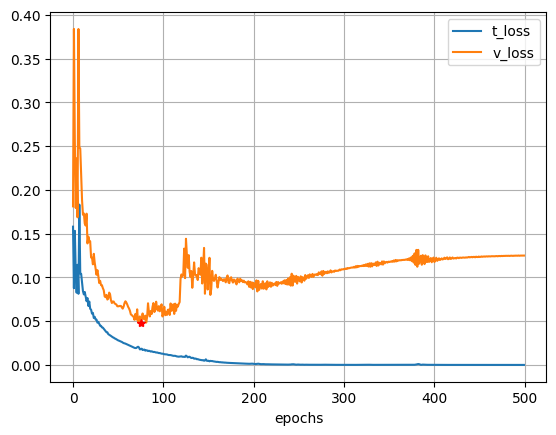

In [21]:
import numpy as np

ep_opt = np.argmin(np.asarray(valloss))
plt.plot([tloss for (tloss, _,_,_) in trainloss], label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.savefig(results_dir + 'learningcurve.jpg')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

In [22]:
torch.save({'epoch': 499,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'trainloss': trainloss[-1],
            'valloss': valloss[-1],},
            results_dir + 'last.pt')

In [31]:
modelname = 'last' #last or best
model_best = LSTM14Attention(h_dim=256, hfc_dim=1024, img_size=IMGSIZE, patch_size=PATCH_SIZE, stride=STRIDE, d_dim=D_DIM, num_layers=1)
model_best.to(device)
model_best.load_state_dict(torch.load(results_dir + f'{modelname}.pt')['model_state_dict'])

print(model_best.imgattention.gamma)
print(test_epoch(model_best,device,trainloader))
print(test_epoch(model_best,device,valloader))

# last epoch
# LSTM12          - 0.0011959155090153217 0.061953626573085785
# LSTM13          - 0.0002495442284271121 0.06324800103902817  
# LSTM14          - 0.0007054965011775493 0.06297238916158676
  # gamma = 1.5
# LSTM14Attention(ruido img padding) - 0.0003160705091431737 0.05899877846240997
# LSTM14Attention_LastImage -          2.722365316003561e-05 0.12615053355693817
# LSTM14Attention_LastImage_Gammalearnable - 7.471557473763824e-05 0.1249714270234108

# minimum val_loss 
# LSTM14Attention_LastImage_Gammalearnable 0.018597146868705748 0.04796375706791878

Parameter containing:
tensor([0.8231], device='cuda:0', requires_grad=True)
7.471556891687214e-05
0.1249714270234108


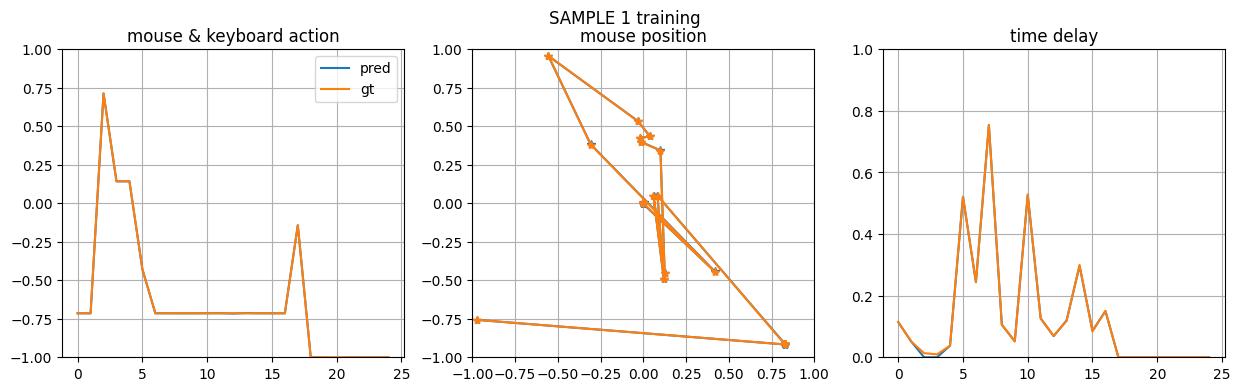

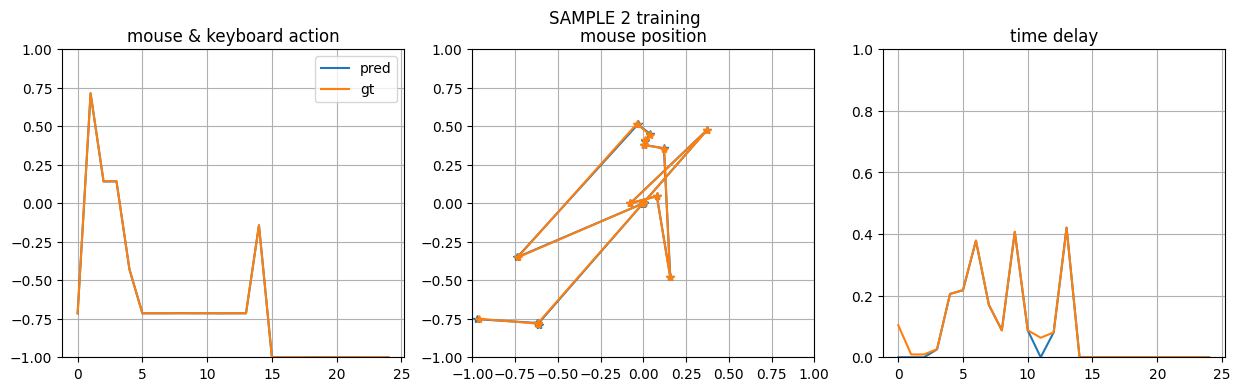

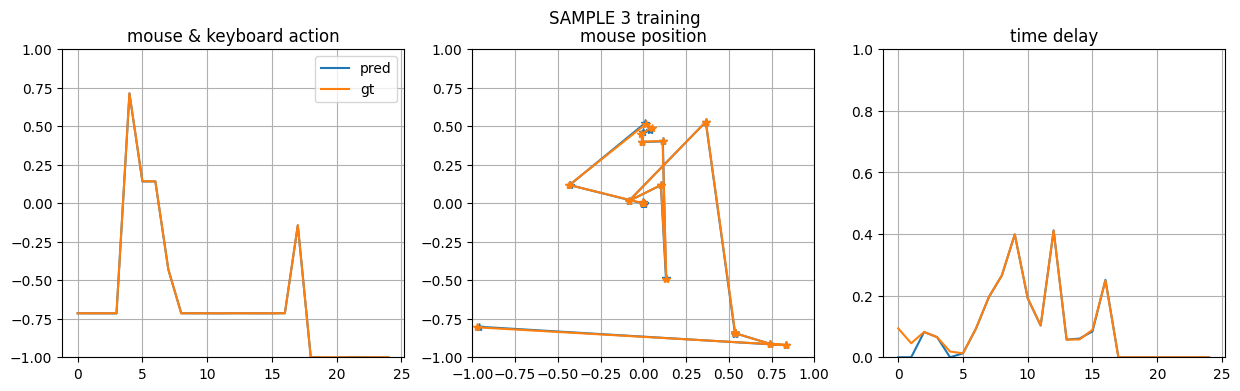

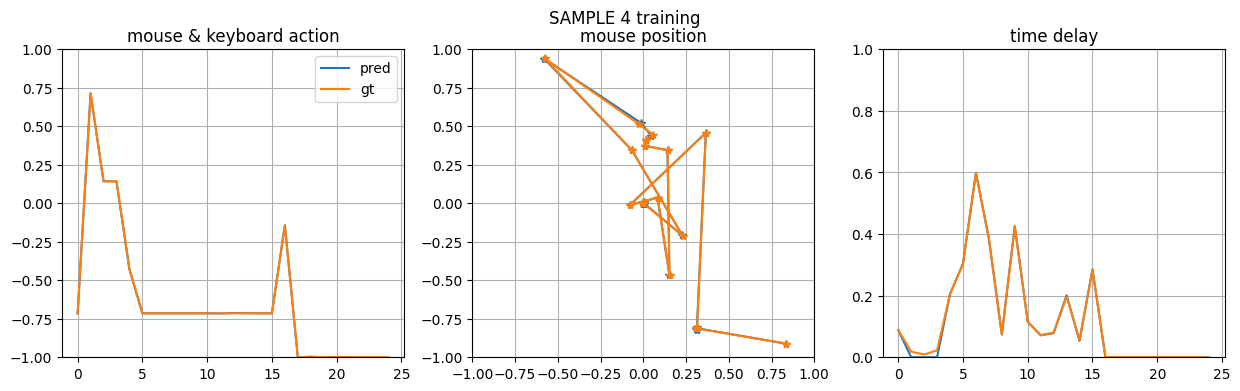

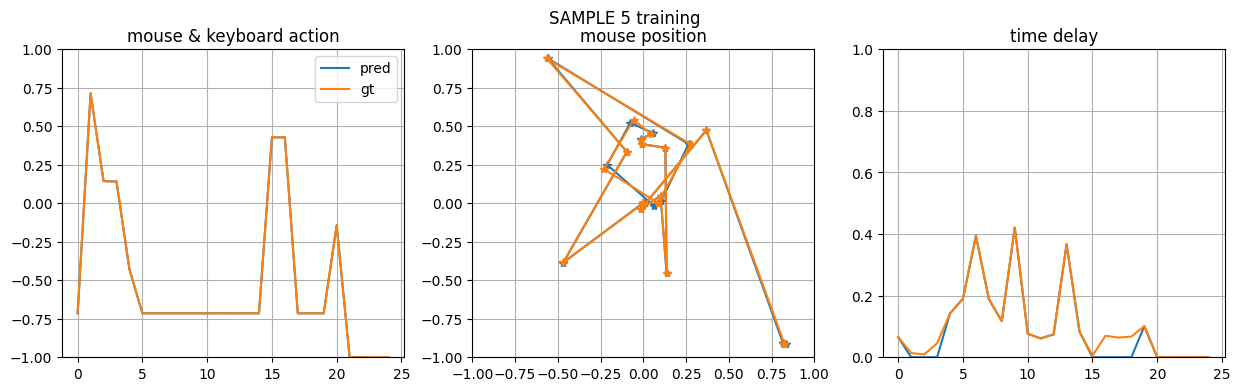

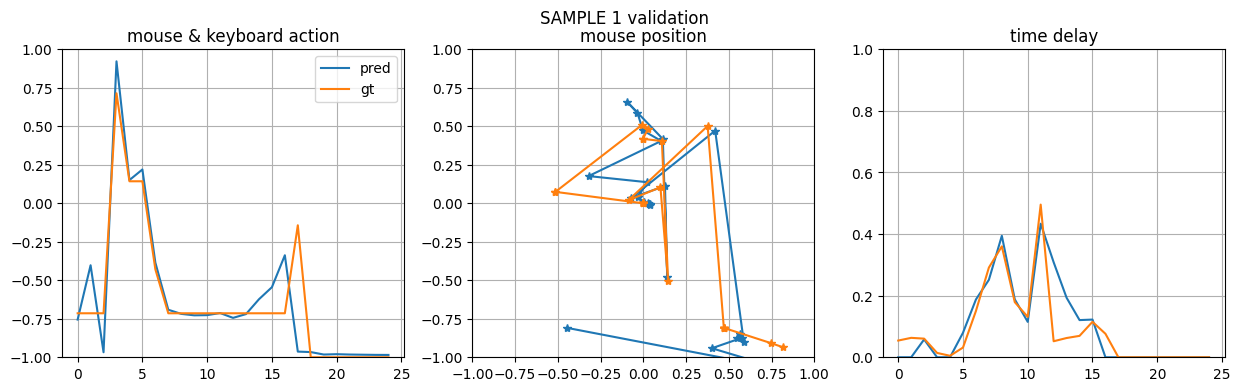

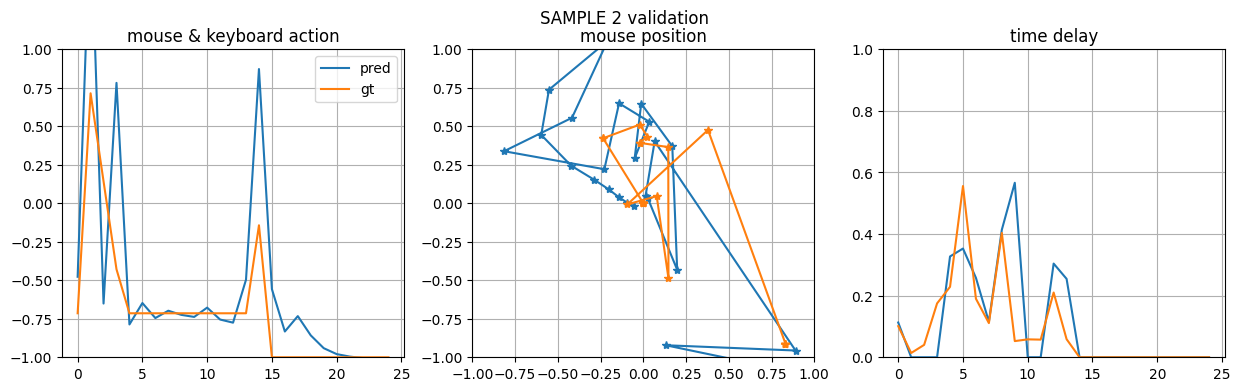

In [32]:
def viz(a, p, d, ib, label):
    a = a[ib].squeeze().detach().cpu().numpy()
    p = p[ib].squeeze().detach().cpu().numpy()
    d = d[ib].squeeze().detach().cpu().numpy()
    plt.subplot(131)
    plt.plot(a, label=label)
    plt.ylim([-1,1])
    plt.grid("on")
    plt.title('mouse & keyboard action')
    plt.legend()
    plt.subplot(132)
    plt.plot(p[:,0], p[:,1], "-*", label=label)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid("on")
    plt.title('mouse position')
    plt.subplot(133)
    plt.plot(d, label=label)
    plt.ylim([0,1])
    plt.grid("on")
    plt.title('time delay')

with torch.no_grad():
    txb, (tab, tpb, tdb) = next(iter(trainloader))
    vxb, (vab, vpb, vdb) = next(iter(valloader))
    xb = torch.cat((txb, vxb), dim=0)
    ab = torch.cat((tab, vab), dim=0)
    pb = torch.cat((tpb, vpb), dim=0)
    db = torch.cat((tdb, vdb), dim=0)
    Nb = txb.shape[0]

for ib in range(xb.shape[0]): 
    xb = xb.to(device)
    ab = ab.to(device)
    pb = pb.to(device)
    db = db.to(device)
    a_pred, p_pred, d_pred = model_best(xb)

    plt.figure(figsize=(15,4))
    if ib < Nb:
        plt.suptitle(f'SAMPLE {ib+1} training')
    else:
        plt.suptitle(f'SAMPLE {ib-Nb+1} validation')
    viz(a_pred, p_pred, d_pred, ib, "pred")
    viz(ab, pb, db, ib, "gt")
    plt.savefig(results_dir + f'{modelname}_prediction_ib={ib}.jpg')
    plt.show()
    

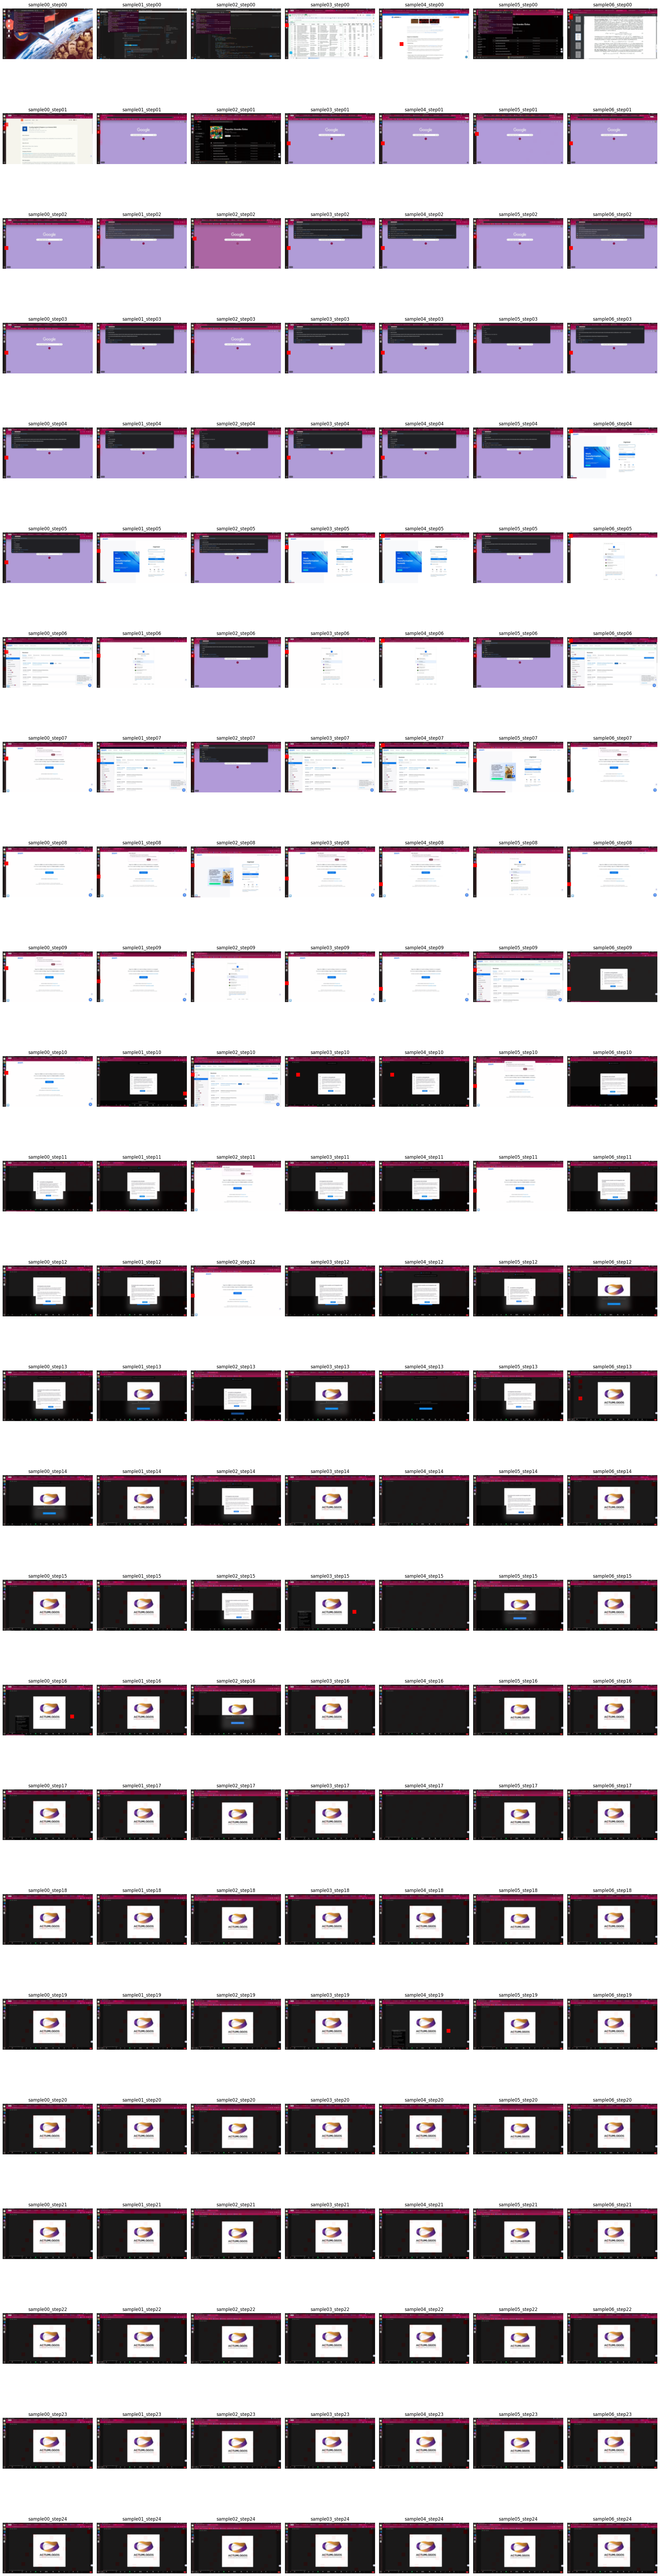

In [33]:
import numpy as np 

def vizAttention(img_batch,patch_imp, iL_max):
    plt.figure(figsize=(25,100))
    for iL in range(iL_max):
        Nx = round((IMGSIZE[0]-PATCH_SIZE)/STRIDE + 1)
        Ny = round((IMGSIZE[1]-PATCH_SIZE)/STRIDE + 1)
        patches_x = np.arange(0,STRIDE*Nx, STRIDE)
        patches_y = np.arange(0,STRIDE*Ny, STRIDE)
        XY = np.meshgrid(patches_x, patches_y)
        patch_positions = np.stack(XY).reshape(2,-1) 

        ib_max = patch_imp.shape[0]
        for ib in range(ib_max):
            img = img_batch[ib,iL,...].permute(1,2,0)
            mask = torch.zeros(img.shape).to(device)
            for n in range(patch_positions.shape[1]):
                i, j = patch_positions[:,n]
                mask[i:i+7+1,j:j+7+1,0] += patch_imp[ib,iL,n]
                mask[i:i+7+1,j:j+7+1,1] -= patch_imp[ib,iL,n]
                mask[i:i+7+1,j:j+7+1,2] -= patch_imp[ib,iL,n]

            Y = torch.clip(img+mask, 0, 1)
            plt.subplot(iL_max,ib_max,iL*ib_max+(ib+1))
            plt.imshow(Y.detach().cpu().numpy())
            plt.title('sample{:02}_step{:02}'.format(ib,iL))
            plt.axis('off')
    plt.tight_layout()
    plt.savefig(results_dir + f'{modelname}_imgattention.jpg')
    plt.show()

vizAttention(img_batch=xb,patch_imp=model_best.patch_imp, iL_max = 25)

In [34]:
print(model_best)

sum(p.numel() for p in model_best.parameters())

LSTM14Attention(
  (imgattention): ImgAttentionDiff(
    (patchify): Unfold(kernel_size=7, dilation=1, padding=0, stride=4)
    (tokeys): Linear(in_features=147, out_features=4, bias=False)
    (toqueries): Linear(in_features=147, out_features=4, bias=False)
  )
  (lstm): LSTM(1222, 256, batch_first=True)
  (fc1_action): Linear(in_features=1478, out_features=1024, bias=True)
  (fc2_action): Linear(in_features=1024, out_features=1, bias=True)
  (fc_position): Linear(in_features=1478, out_features=2, bias=True)
  (fc_delay): Linear(in_features=1478, out_features=1, bias=True)
)


3036655